# EfficientNet

In [16]:
learning_rate = 1e-4

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import cv2

import os
import time 
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

In [12]:
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.9.2


# Scelta CNN e creazione fully connected network

In [3]:
inputshape = [96, 96, 3]
effnet = tf.keras.applications.EfficientNetB3(include_top=False, input_shape=inputshape, weights = "imagenet")

for layer in effnet.layers:
	layer.trainable = True

43941136/43941136 [==============================] - 0s 0us/step


Trying with two hidden layers

In [4]:
def create_model_085acc (input_shape, convnet):
  # mark loaded layers as not trainable

  dropout_rate = 0.2
  dropout_rate1 = 0.5

    # Build the model
  input_layer = convnet.layers[0].input
  flat1 = Flatten()(convnet.layers[-1].output)
  flat1 = tfkl.Dropout(dropout_rate, seed=seed)(flat1)
  hidden_layer1 = tfkl.Dense(units=512, activation='relu', name='Hidden1',
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(flat1)
  hidden_layer1 = tfkl.Dropout(dropout_rate, seed=seed)(hidden_layer1)
  hidden_layer2 = tfkl.Dense(units=256, activation='relu', name='Hidden2', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer1)
  hidden_layer2 = tfkl.Dropout(dropout_rate1, seed=seed)(hidden_layer2)
  output = tfkl.Dense(units=8, activation='softmax', name='Output', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer2)
    # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output, name='model')

    # Compile the model
  # qualcosa (reduce) on plateau
  opt = tfk.optimizers.Adam(learning_rate)
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=opt, metrics='accuracy')

    # Return the model
  return model

In [5]:
# summarize

model = create_model_085acc(input_shape = inputshape, convnet = effnet)
model.summary()

#tfk.utils.plot_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 96, 96, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 96, 96, 3)    0           ['normalization[0][0]']          
                                                                                              

#  Splitting the dataset and Data augmentation

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Mounted at /gdrive
/gdrive/My Drive


In [10]:
data_dir="training_data_final"
batch_size = 16
img_height = 96
img_width = 96

In [31]:
training_dir = data_dir
from keras_preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
aug_train_data_gen = ImageDataGenerator(rotation_range=30, 
                                        height_shift_range=50, 
                                        width_shift_range=50, 
                                        zoom_range=0.3, 
                                        horizontal_flip=True, 
                                        vertical_flip=True,  
                                        fill_mode='reflect',
                                        rescale=1/255, 
                                        validation_split=0.2)
train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=True,
                                               seed=seed,
                                               subset="training")

valid_gen = data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               #classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=True,
                                               seed=seed,
                                               subset="validation")



Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [9]:
countclass=[0,0,0,0,0,0,0,0]
for i in train_gen.classes:
  countclass[i] = countclass[i] + 1;

print(countclass)

tot = len(train_gen.classes)

print(tot)

weights = np.zeros(8, dtype=float)
for x in range(8):
  weights[x] = tot/countclass[x]

weights = weights.astype(int)

print(weights)

[149, 426, 412, 409, 425, 178, 430, 407]
2836
[19  6  6  6  6 15  6  6]


In [21]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('efficientnet_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, '{val_loss:.4f}-{loss:.4f}-f_model.h5'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True, # True to save only the best epoch
                                                     monitor='val_accuracy')  
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

# Training

In [29]:
callbacks = create_folders_and_callbacks(model_name='CNN_Effnet')

# Train the model
tl_history = effnet.fit(
    train_gen,
    epochs = 80,
    validation_data = valid_gen,
    class_weight = {0:19,  1:6,  2:6,  3:6,  4:6, 5:15,  6:6,  7:6},
    callbacks=callbacks
).history

Epoch 1/80
45/45 [==============================] - 48s 757ms/step - loss: 1.3013 - accuracy: 0.9404 - val_loss: 0.5485 - val_accuracy: 0.8612
Epoch 2/80
45/45 [==============================] - 29s 657ms/step - loss: 1.2935 - accuracy: 0.9386 - val_loss: 0.5585 - val_accuracy: 0.8584
Epoch 3/80
45/45 [==============================] - 29s 640ms/step - loss: 1.4721 - accuracy: 0.9330 - val_loss: 0.5554 - val_accuracy: 0.8598
Epoch 4/80
45/45 [==============================] - 29s 639ms/step - loss: 1.2763 - accuracy: 0.9362 - val_loss: 0.5766 - val_accuracy: 0.8470
Epoch 5/80
45/45 [==============================] - 29s 639ms/step - loss: 1.4193 - accuracy: 0.9362 - val_loss: 0.5858 - val_accuracy: 0.8456
Epoch 6/80
45/45 [==============================] - 28s 634ms/step - loss: 1.4617 - accuracy: 0.9341 - val_loss: 0.5877 - val_accuracy: 0.8399
Epoch 7/80
45/45 [==============================] - 29s 639ms/step - loss: 1.3497 - accuracy: 0.9436 - val_loss: 0.5745 - val_accuracy: 0.8470

KeyboardInterrupt: ignored

In [ ]:
effnet = tf.keras.models.load_model('efficientnet_experiments/CNN_Effnet_Nov17_16-34-30/ckpts/0.5332-1.2749-f_model.h5')
effnet.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-6), metrics='accuracy')

# Update the learning rate and restart
tl_history = effnet.fit(
    train_gen,
    epochs = 80,
    validation_data = valid_gen,
    class_weight = {0:19,  1:6,  2:6,  3:6,  4:6, 5:15,  6:6,  7:6},
    callbacks=callbacks
).history

# Result analysis with confusion matrix

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

def plot_confusionMatrix(test_labels, test_predicted):
  cm = confusion_matrix(test_labels, test_predicted, labels=[0,1,2,3,4,5,6,7])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot()
  plt.show()
  return

In [27]:
def testModel( valid_gen, model):

  # d. Predit test labels
  test_predicted = model.predict(valid_gen)
  test_predicted = np.argmax(test_predicted, axis=-1)
  

  # e. plot confusion matrix
  plot_confusionMatrix(valid_gen.classes, test_predicted)

  # f. display classification results
  print(classification_report(valid_gen.classes, test_predicted, target_names=labels))

706/706 [==============================] - 14s 16ms/step


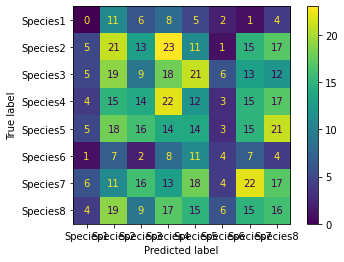

              precision    recall  f1-score   support

    Species1       0.00      0.00      0.00        37
    Species2       0.17      0.20      0.19       106
    Species3       0.11      0.09      0.10       103
    Species4       0.18      0.22      0.20       102
    Species5       0.13      0.13      0.13       106
    Species6       0.14      0.09      0.11        44
    Species7       0.21      0.21      0.21       107
    Species8       0.15      0.16      0.15       101

    accuracy                           0.15       706
   macro avg       0.14      0.14      0.14       706
weighted avg       0.15      0.15      0.15       706



In [32]:
effnet = tf.keras.models.load_model('efficientnet_experiments/CNN_Effnet_Nov17_17-19-58/ckpts/0.5485-1.3013-f_model.h5')
testModel(valid_gen, effnet)